# CNN Supervised Learning #

Using my hand-coded data set, in this notebook, I find the most effective machine learning models for classification.

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

In [2]:
cnn_df = pd.read_excel('../data/interim/cnn_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
cnn_df.head()

,identifier,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,isad,contributor,...,has_prev_appreciate,has_next_appreciate,has_prev_ahead,has_prev_return,has_prev_after this,has_prev_go away,has_next_good evening,has_prev_applause,has_next_applause,has_prev_tuned
0,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,"now the fastest, most reliable internet can he...",1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
1,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,"that's simple, easy, awesome.",1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
2,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,taxi!,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
3,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,should i have stopped her?,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
4,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,save hundreds of dollars a year when you get i...,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = np.array(cnn_df['isad'])
X = cnn_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['thats why were working on ways to improve it',
 'theres no changing democrats got a benefit from an unusually large number of voters in  people who hadnt votds in  who turned up and voted predomitly for democrats',
 'otherwise we just wont be able to do business',
 ' she would move to canada if you got elected',
 'do you see it as an unrealistic position']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [8]:
X_train_bow = vect.fit_transform(corpus_train)

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [9]:
X_test_bow = vect.transform(corpus_test)

In [10]:
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())

In [11]:
X_train_joined = X_train.reset_index().join(X_train_bow_df).drop(columns=['index'])

In [12]:
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_joined = X_test.reset_index().join(X_test_bow_df).drop(columns=['index'])

In [13]:
X_train_joined = X_train_joined.drop(columns=['sentence'])
X_test_joined = X_test_joined.drop(columns=['sentence'])

In [14]:
log = LogisticRegression(max_iter=10000)
log.fit(X_train_joined, y_train)
log_score = log.score(X_test_joined, y_test)
print('Logistic Regression Score: {}'.format(log_score))

Logistic Regression Score: 0.792


[[2105   41]
 [ 583  271]]


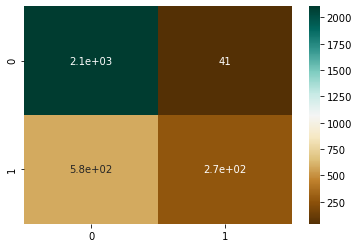

In [15]:
pred = log.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [16]:
rmse_val = []

for K in range(10):
    K = K+1
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    model.fit(X_train_joined, y_train)  #fit the model
    pred=model.predict(X_test_joined) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.5366563145999496
RMSE value for k=  2 is: 0.5099019513592785
RMSE value for k=  3 is: 0.5183306537980044
RMSE value for k=  4 is: 0.4996665554814197
RMSE value for k=  5 is: 0.5003332222962347
RMSE value for k=  6 is: 0.4949747468305833
RMSE value for k=  7 is: 0.4969909455915671
RMSE value for k=  8 is: 0.4919349550499537
RMSE value for k=  9 is: 0.4875106836436168
RMSE value for k=  10 is: 0.49023803741991845


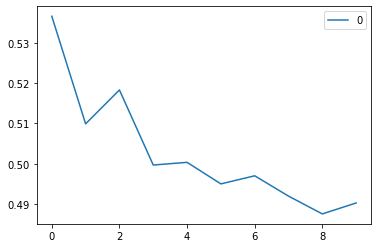

In [17]:
#elbow curve 
curve = pd.DataFrame(rmse_val) 
curve.plot()

In [18]:
model = neighbors.KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_joined, y_train)
model.score(X_test_joined, y_test)

0.7496666666666667

[[1789  357]
 [ 394  460]]


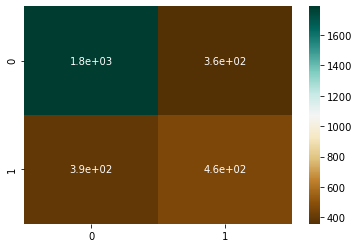

In [19]:
pred = model.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [40]:
svc = SVC()
svc.fit(X_train_joined, y_train)
score = svc.score(X_test_joined, y_test)
print('SVC Score is: {}'.format(score))

SVC Score is: 0.7153333333333334


[[2146    0]
 [ 854    0]]


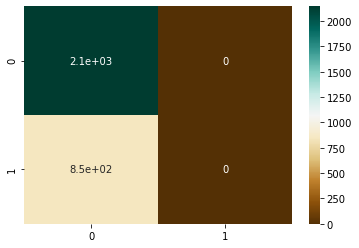

In [41]:
pred = svc.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [42]:
lsvc = LinearSVC(max_iter=100000)

In [43]:
lsvc.fit(X_train_joined, y_train)
score = lsvc.score(X_test_joined, y_test)
print('Linear SVC Score is: {}'.format(score))

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Linear SVC Score is: 0.7406666666666667


[[2142    4]
 [ 774   80]]


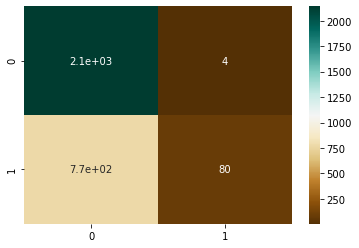

In [44]:
pred = lsvc.predict(X_test_joined)
c=confusion_matrix(y_test, pred)
sns.heatmap(c,cmap='BrBG',annot=True)
print(c)
plt.show()

In [45]:
sgdc = SGDClassifier(loss='log', penalty='l1')
sgdc.fit(X_train_joined, y_train)
score = sgdc.score(X_test_joined, y_test)
print('SGDC score is: {}'.format(score))

SGDC score is: 0.5403333333333333


In [46]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

[[1109 1037]
 [ 342  512]]


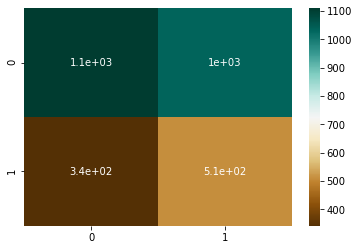

In [47]:
plot_confusion_matrix(sgdc, X_test_joined, y_test)

In [48]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train_joined, y_train)
score = dtc.score(X_test_joined, y_test)
print('DTC score is: {}'.format(score))

DTC score is: 0.803


[[1845  301]
 [ 290  564]]


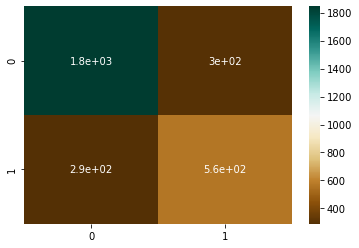

In [49]:
plot_confusion_matrix(dtc, X_test_joined, y_test)

In [50]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_joined, y_train)
score = rfc.score(X_test_joined, y_test)
print('RFC score is: {}'.format(score))

RFC score is: 0.8523333333333334


[[2014  132]
 [ 311  543]]


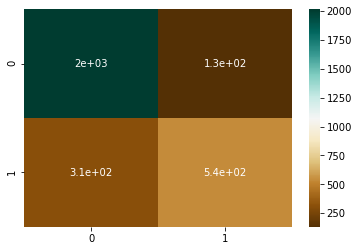

In [51]:
plot_confusion_matrix(rfc, X_test_joined, y_test)

In [52]:
bc = ensemble.BaggingClassifier()
bc.fit(X_train_joined, y_train)
score = bc.score(X_test_joined, y_test)
print('bc score is: {}'.format(score))

bc score is: 0.8216666666666667


[[1966  180]
 [ 355  499]]


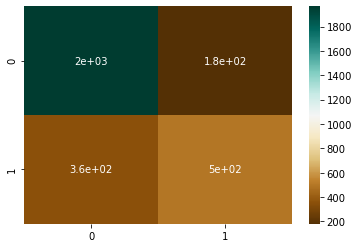

In [53]:
plot_confusion_matrix(bc, X_test_joined, y_test)

In [54]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train_joined, y_train)
score = gbc.score(X_test_joined, y_test)
print('gbc score is: {}'.format(score))

gbc score is: 0.785


[[2127   19]
 [ 626  228]]


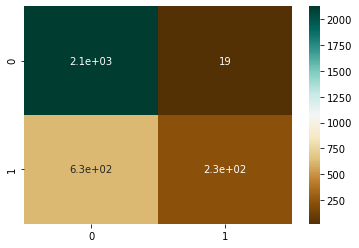

In [55]:
plot_confusion_matrix(gbc, X_test_joined, y_test)

In [56]:
abc = ensemble.AdaBoostClassifier()
abc.fit(X_train_joined, y_train)
score = abc.score(X_test_joined, y_test)
print('abc score is: {}'.format(score))

abc score is: 0.7846666666666666


[[1953  193]
 [ 453  401]]


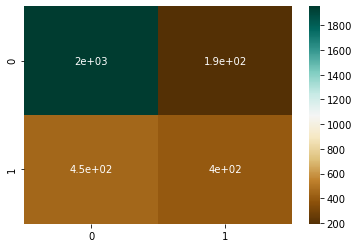

In [57]:
plot_confusion_matrix(abc, X_test_joined, y_test)